In [24]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
NFFT = 2048 # Количество точек БПФ

## Банки фильтров
Последним шагом к вычислению банков фильтров является применение треугольных фильтров, обычно 40 фильтров, по шкале Мела, к спектру мощности для выделения частотных диапазонов. Шкала Мела направлена на то, чтобы имитировать нелинейное восприятие звука человеческим ухом, будучи более различимой на более низких частотах и менее различимой на более высоких частотах. Мы можем конвертировать между Герцами (f) и Mel (m), используя следующие уравнения:
$$m = 2595 \log_{10} \left(1+\frac{f}{700}\right), \quad\quad\quad(4)$$
$$f = 700 \left(10^{\frac{m}{2595}}-1\right).\quad\quad\quad(5)$$

Каждый фильтр в банке фильтров имеет треугольную форму с откликом 1 на центральной частоте и линейно уменьшается к 0, пока не достигнет центральных частот двух соседних фильтров, где отклик равен 0. Это можно смоделировать с помощью следующего уравнения: 
$$
H_m (k)=
\begin{cases}
   0, &\text{ $k<f(m-1)$},\\
   \frac{k-f(m-1)}{f(m)-f(m-1)}, &\text{ $f(m-1) \leq k < f(m)$},\\
   \frac{f(m+1)-k}{f(m+1)-f(m)}, &\text{ $f(m) \leq k \leq f(m+1)$},\\
   0, &\text{ $k > f(m+1)$}.
 \end{cases}
\quad\quad\quad(6)
$$
$f$ - список из $M+2$ меловых частот. 

In [26]:
nfilt = 40
low_freq_mel = (2595 * np.log10(1 + (44100 / 2048) / 700))
high_freq_mel = (2595 * np.log10(1 + (44100 / 2) / 700))  # Конвертирование Гц в Мел
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Точки, равномерно расположенные по мел-шкале
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Конвертирование Мел в Гц

# У нас нет разрешения по частоте, необходимого для установки фильтров в точных точках, рассчитанных выше, 
# поэтому нам нужно округлить эти частоты до ближайшего бина БПФ. Этот процесс не влияет на точность признаков. 
# Чтобы преобразовать частоты в числа бинов БПФ, нам нужно знать размер БПФ и частоту дискретизации.
bin = np.floor((NFFT + 1) * hz_points / sample_rate)
print(bin)

# Мы можем видеть, что окончательный банк фильтров заканчивается на бине 1024, 
# что соответствует 10 кГц с размером БПФ в 2048 точек.

 
fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))

for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # левая сторона
    f_m = int(bin[m])             # центр
    f_m_plus = int(bin[m + 1])    # правая сторона
 
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
fbank1 = [f[0] for f in fbank.T]

[1.000e+00 3.000e+00 7.000e+00 1.000e+01 1.400e+01 1.800e+01 2.300e+01
 2.700e+01 3.300e+01 3.800e+01 4.500e+01 5.200e+01 5.900e+01 6.700e+01
 7.600e+01 8.500e+01 9.600e+01 1.070e+02 1.190e+02 1.330e+02 1.470e+02
 1.630e+02 1.810e+02 1.990e+02 2.200e+02 2.420e+02 2.660e+02 2.920e+02
 3.210e+02 3.520e+02 3.860e+02 4.230e+02 4.630e+02 5.060e+02 5.530e+02
 6.050e+02 6.610e+02 7.220e+02 7.880e+02 8.600e+02 9.390e+02 1.024e+03]


Text(0.5, 1.0, 'The full filterbank')

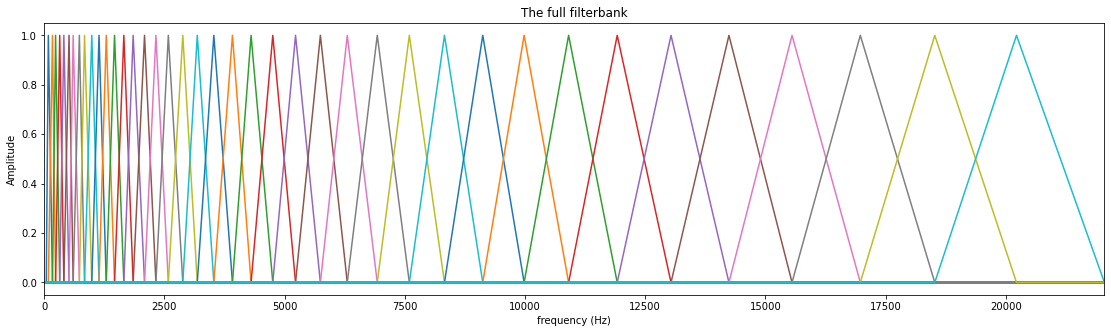

In [27]:
fig, ax = plt.subplots(1, figsize=(19, 5))
freq = np.linspace(44100/2048,44100/2,int(np.floor(NFFT / 2 + 1)))
ax.plot(freq, fbank.T)
ax.set_xlim([0, sample_rate/2])
plt.xlabel('frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('The full filterbank')